## Short-term prediction using LSTM and IBTrACS

v01: Uses PyTorch with GPU. Lagging features are considered as features, so train tensors have a shape (n_samples, timestamp, n_features) = (n_samples, 1, 20) instead of (n_samples, 4, 5).
Doesn't implement Minibatches, Dataset or DataLoader.

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import pytorch_lightning as pl


# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils    as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### PARAMS
PARAMS = {'num_classes': 5,     # nb of output features
          'input_size':  5,     # nb of input features
          'hidden_size': 2,     # nb of features in hidden state
          'num_layers':  1,     # nb of stacked lstm layers
          
          'num_epochs':  1,     # nb of epochs
          'learn_rate':  0.001, # learning rate
          
          'seq_len':         4, # length of the input time series used to predict y(t)
          'save_figs':       False,
          'feature_scaling': True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'lstm_path':    '/home/arthur/results/TCsLifeMonitFromObs/lstm_dynamic_pred_ibtracs/lstmv01.pth', 
}

### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'nature']

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
### FILTERS
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# By latitude
ds_ibt     = ds_ibt.where(np.abs(ds_ibt['lat']) <= 30)
# By removing empty Rmax time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_rmw'].notnull().sum(axis=1) > 5)
# By removing empty R34 time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_r34'].notnull().sum(axis=1) > 5) 

# ==> Drop NaNs
ds_ibt     = ds_ibt.dropna(dim='storm', how='all') # Much quicker to drop NaNs only at the end

In [6]:
# LR_variables = ['usa_lon', 'usa_lat', 'usa_r34']
# ds_ibt_LR    = ds_ibt[LR_variables]
# ds_ibt_LR

In [7]:
### CREATE DATASET (Train and test)
# FIRST WE AVERAGE OVER EVERY QUADRANT
# Pre-processing
MU    = {}
SIG   = {}
SCALE = {'usa_wind': 3,
         'usa_rmw':  3, 
         'usa_r34':  2,
         'usa_lon':  0.5,
         'usa_lat':  1,
}
if PARAMS['feature_scaling']:
    for param in params_of_interest:
        MU[param]     = float(ds_ibt[param].mean(skipna=True))
        SIG[param]    = float(ds_ibt[param].std(skipna=True))
        ds_ibt[param] = SCALE[param] * ((ds_ibt[param] - MU[param]) / SIG[param])

# Separate train and test set
sep = int(0.8 * len(ds_ibt['storm'])) # 80% train, 20% test
ds_train, ds_test = ds_ibt.isel(storm=slice(None, sep)), ds_ibt.isel(storm=slice(sep, None))
print('Train set: %i storms;  '%len(ds_train['storm']), 'Test set: %i storms'%len(ds_test['storm']))

# Create Dataset
X_train, y_train = du.create_dataset(ds_train, params_of_interest, PARAMS)
X_test, y_test   = du.create_dataset(ds_test,  params_of_interest, PARAMS)
print('Shape of predictors matrix X_train: ', np.asarray(X_train).shape)
print('Shape of targets matrix y_train: ', np.asarray(y_train).shape)

Train set: 188 storms;   Test set: 48 storms


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 55.39it/s]

Shape of predictors matrix X_train:  (2432, 20)
Shape of targets matrix y_train:  (2432, 5)


In [8]:
### CONVERT TO TENSORS WITH APPROPRIATE SHAPES
# Convert to tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors  = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors  = Variable(torch.Tensor(y_test))

# Reshape from (n_samples, n_features) to (n_samples, 1, n_features) where 1 symbolizes timestamp
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final  = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0],  1, X_test_tensors.shape[1])) 
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
        
# STRUCTURE OF X_current
# [usa_lon(t-4), usa_lon(t-3), usa_lon(t-2), ...., usa_rmw(t-3), usa_rmw(t-2), usa_rmw(t-1)] in the same way like params_of_interest
# e.g params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw']
# STRUCTURE OF y
# [usa_lon(t), usa_lat(t), usa_wind(t), usa_r34(t), usa_rmw(t)]

Training Shape torch.Size([2432, 1, 20]) torch.Size([2432, 5])
Testing Shape torch.Size([692, 1, 20]) torch.Size([692, 5])


In [9]:
# Declare model
lstm1 = pu.LSTM1(num_classes=PARAMS['num_classes'],
                 input_size=PARAMS['input_size'] * PARAMS['seq_len'],
                 hidden_size=PARAMS['hidden_size'],
                 num_layers=PARAMS['num_layers'],
                 seq_len=PARAMS['seq_len'],             
)
print(lstm1)

# Loss function, optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=PARAMS['learn_rate']) 

LSTM1(
  (lstm): LSTM(20, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
)


In [10]:
# Move model and Train set to GPU
lstm1.to(device)
X_train_tensors_final = X_train_tensors_final.to(device)
y_train_tensors       = y_train_tensors.to(device)
# NB LSTM() model also moves tensors to device inside the class (for hidden tensors)

# Training
for epoch in range(2000):
    outputs = lstm1.forward(X_train_tensors_final) # forward pass
    optimizer.zero_grad() # caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() # calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

# Save model
torch.save(lstm1.state_dict(), PATHS['lstm_path'])

Epoch: 0, loss: 4.50825
Epoch: 100, loss: 2.95047
Epoch: 200, loss: 1.97717
Epoch: 300, loss: 1.72302
Epoch: 400, loss: 1.56278
Epoch: 500, loss: 1.35803
Epoch: 600, loss: 0.98448
Epoch: 700, loss: 0.79141
Epoch: 800, loss: 0.74102
Epoch: 900, loss: 0.71017
Epoch: 1000, loss: 0.68939
Epoch: 1100, loss: 0.67345
Epoch: 1200, loss: 0.66160
Epoch: 1300, loss: 0.65257
Epoch: 1400, loss: 0.64557
Epoch: 1500, loss: 0.64010
Epoch: 1600, loss: 0.63551
Epoch: 1700, loss: 0.63174
Epoch: 1800, loss: 0.62854
Epoch: 1900, loss: 0.62580


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 63.91it/s]


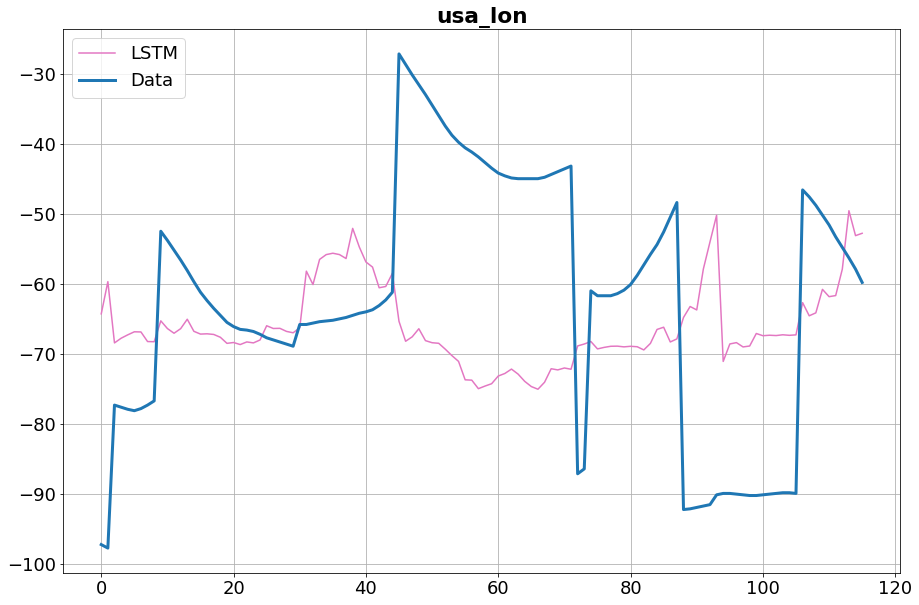

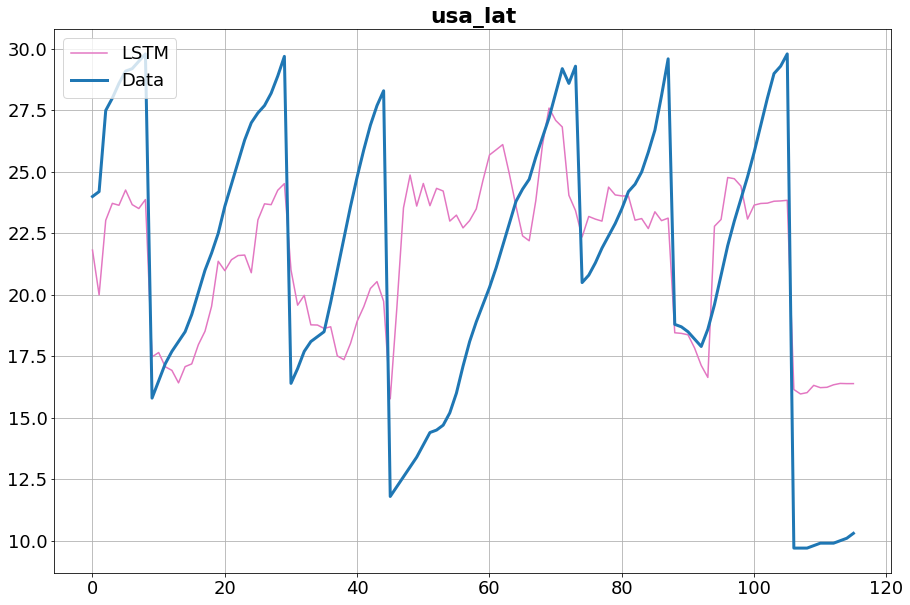

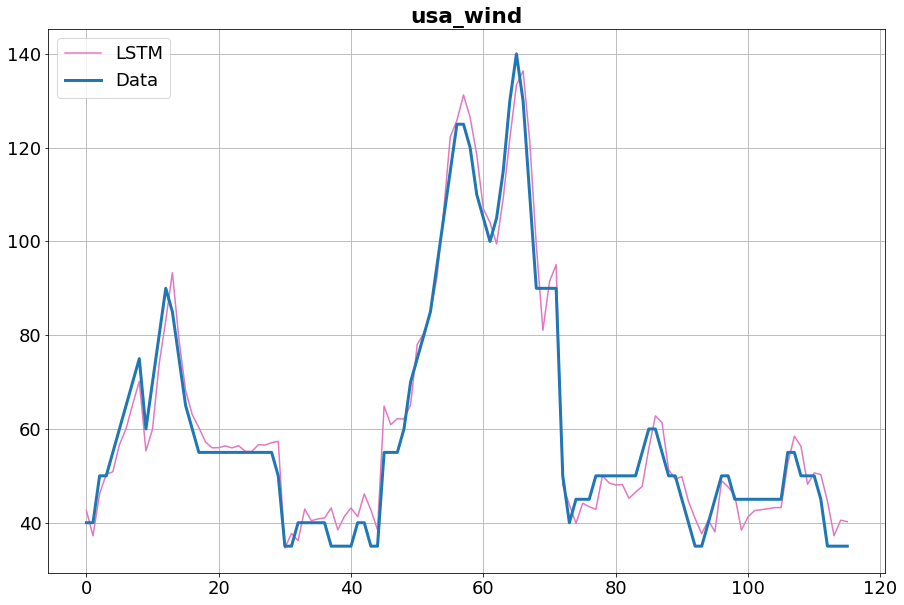

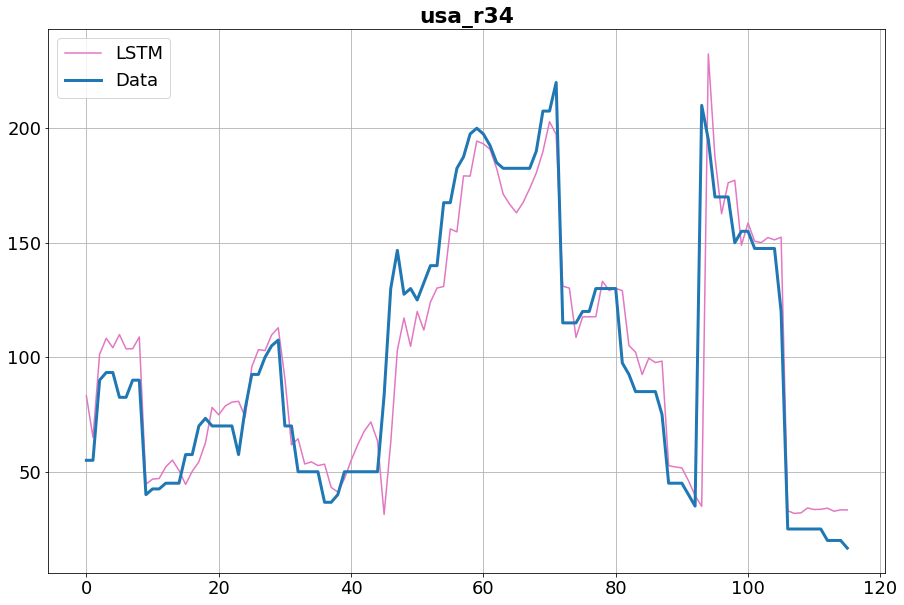

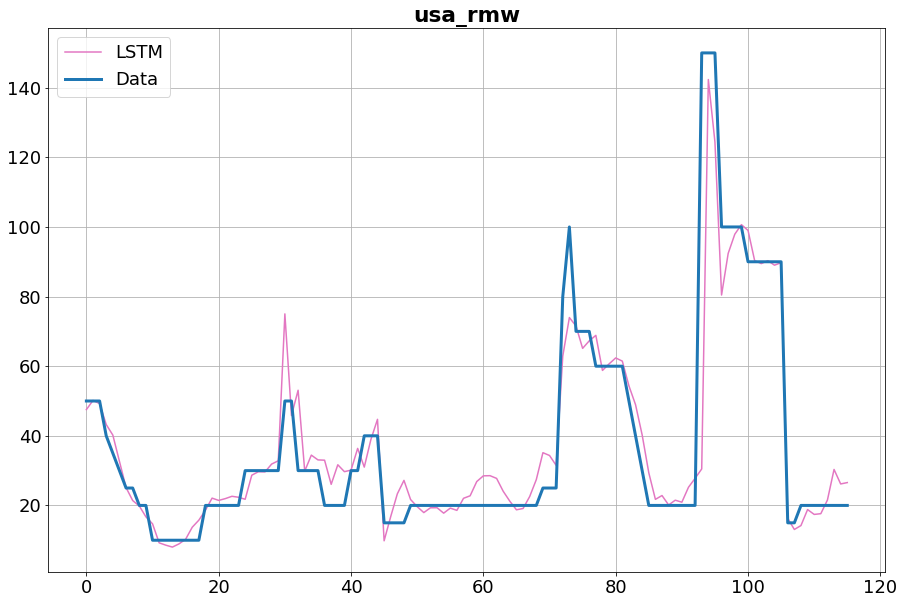

In [11]:
# Prepare inference data
X_im, y_im         = du.create_dataset(ds_test.isel(storm=slice(-30, -20)),  params_of_interest, PARAMS)
y_im               = np.array(y_im)
X_im_tensors       = Variable(torch.Tensor(X_im))
X_im_tensors_final = torch.reshape(X_im_tensors, (X_im_tensors.shape[0], 1, X_im_tensors.shape[1]))

# Inference
lstm1.eval()
lstm1.cpu()
with torch.no_grad():
    pred = lstm1(X_im_tensors_final)

# Plot
for i, param in enumerate(params_of_interest):
    feature = pred[:, i].cpu().detach().numpy()
    feature = du.inverse_scale_normalize(feature, MU, SIG, SCALE, param)
    target  = y_im[:, i]
    target  = du.inverse_scale_normalize(target,  MU, SIG, SCALE, param)
    plt.title(param, weight='bold')
    plt.plot(feature, label='LSTM', color='tab:pink')
    plt.plot(target,  label='Data', linewidth=3, color='tab:blue')
    plt.legend(loc='upper left');plt.grid()
    plt.show()